In [ ]:
###############################################
# Student_Number : 99131009                   #
# Name : Najmeh                               #
# Last Name : Mohammadbagheri                 #
# E-mail : Najmeh.mohammadbagheri77@gmail.com #
###############################################

In [ ]:
import cv2
import numpy as np
from scipy.stats import norm
import math
import random
import sys
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, rgb2gray
import os
from skimage.feature import greycomatrix, greycoprops
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

In [ ]:
os.chdir('/content/drive/My Drive/pgm')

In [ ]:
def load_image(filename):
    return plt.imread(filename)

# part 1(a,b) --> Naive Bayes

In [ ]:
def add_gauss_noise(image,var):
    row, col, ch = image.shape
    mean = 0
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col,ch))
    gauss = gauss.reshape(row, col,ch)
    noisy_img = image + gauss
    return noisy_img


def prior_prob(image):

    # parameters
    p_l0 = 0  # prior probability for label 0 (Intensity = 0)
    p_l1 = 0  # prior probability for label 1 (Intensity = 127)
    p_l2 = 0  # prior probability for label 2 (Intensity = 255)

    height, width, ch = image.shape

    for i in range(height):
        for j in range(width):
            if image[i,j,0] == 0:
                p_l0 += 1
            elif image[i,j,1] == 127:
                p_l1 +=1
            elif image[i,j,0] == 255:
                p_l2 += 1
    return p_l0/(height*width), p_l1/(height*width), p_l2/(height*width)


def set_likelihood_prob(img):
    var =[0,0,0]
    mu = [0,0,0]
    # black
    var[0]= np.var(img[1:100,1:100])
    mu[0]= np.mean(img[1:100,1:100])

    # for i in range(1,100):
    #     for j in range(1,100):
    #         img[i,j] = 255
    # plt.imshow(img)
    
    
    # gray
    var[1]= np.var(img[101:200,1:100])
    mu[1]= np.mean(img[101:200,1:100])

    # for i in range(101,200):
    #     for j in range(1,100):
    #         img[i,j] = 255
    # plt.imshow(img)
    
    
    # white
    var[2]= np.var(img[151:255,151:251])
    mu[2] = np.mean(img[151:255,151:251])

    # for i in range(151,255):
    #     for j in range(151,251):
    #         img[i,j] = 255
    # plt.imshow(img)


    ## this settenig after resizing test1.bmp 
    
    # var[0]= np.var(img[1:25,1:25])
    # mu[0]= np.mean(img[1:25,1:25])
    # var[1]= np.var(img[25:50,1:25])
    # mu[1]= np.mean(img[25:50,1:25])
    # var[2]= np.var(img[38:63,38:62])
    # mu[2] = np.mean(img[38:63,38:62])


    return var,mu
    


def naive_bayes_segmentaiton(noisy_img, p_l0, p_l1, p_l2):
    height, width, ch = noisy_img.shape
    labels = np.empty([height,width])
    var , mu = set_likelihood_prob(noisy_img)
    for i in range(height):
        for j in range(width):
            # average of 3 channels
            pixel = np.average(noisy_img[i,j,:])

            # calculate p(Intensity|label)
            l0 = norm(mu[0], var[0]).pdf(pixel)
            l1 = norm(mu[1], var[1]).pdf(pixel)
            l2 = norm(mu[2], var[2]).pdf(pixel)

            # calculate p(label|Intensity)
            labels[i,j] = np.argmax(np.array([l0*p_l0, l1*p_l1, l2*p_l2]))

    return labels


def accuracy(true_img, pred_img):

    height, width, ch = true_img.shape
    counter = 0
    for i in range(height):
        for j in range(width):
            if true_img[i,j,0] == pred_img[i,j,0]:
                counter += 1
    return counter/(height*width)

  
def segmentaion(labels):
    segmented_image = np.zeros((labels.shape[0], labels.shape[1], 3), np.uint8)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] == 0:
                label = 0
                # segmented_image[i, j, :] = [0, 0, 255]
            elif labels[i,j] == 1:
                label = 127
                # segmented_image[i, j, :] = [255, 0, 0]
            elif labels[i,j] == 2:
                label= 255
                # segmented_image[i, j, :] = [0, 255, 0]
            segmented_image[i,j,:] = [label,label,label]
    return segmented_image



In [ ]:
    img = load_image('test1.bmp')
    
    # calculate prior probability
    var = 0.05
    p_l0, p_l1, p_l2 = prior_prob(img)

    img_p = img / 255.
    set_likelihood_prob(noisy_img)
    print("noisy_image")
    plt.imshow(noisy_img)
    plt.axis('off')
    plt.show()

    naive bayes classifier
    labels = naive_bayes_segmentaiton(noisy_img, p_l0, p_l1, p_l2)
    segmented_image = segmentaion(labels)
    plt.imshow(segmented_image / 255.)
    plt.axis('off')
    plt.show()

    # # calculate and print accuracy
    print('accuracy is: ', accuracy(img,segmented_image))


# part 1(c) --> MRF

In [ ]:
def feature_label_factor(w_s, fs):
    var_s = var_dict.get(w_s)
    mu_s = mu_dict.get(w_s)
    if len(fs) == 1 :
        likelihood_factor = np.log(math.sqrt(var_s[0] * 2 * math.pi ))+ (0.5 * (np.dot(np.transpose(fs - mu_s), fs - mu_s)) / var_s[0])
    else:
        first = np.log(math.sqrt(abs(np.linalg.det(var_s)) * pow(2 * math.pi, len(fs))))
        second = (0.5 * np.dot((np.dot(np.transpose(fs - mu_s),np.linalg.inv(var_s))),fs - mu_s))
        likelihood_factor = first + second

    return likelihood_factor

def delta(w_s, w_r):

    if w_r == w_s:
        return -1
    else:
        return +1


def clique_energy(W,F,row,col,betha,mode,neighbor_mode, prev_u, prev_w):
    height = W.shape[0]
    width = W.shape[1]
    u = prev_u
    if mode == 1:
        for i in range(height):
            for j in range(width):
                fs = F[i,j,:]
                u += feature_label_factor(W[i,j],fs)
                #  4 neighbors ( '+' shape)
                if i != 0 :
                    u += betha * delta(W[i,j],W[i-1,j])
                if i != height-1:
                    u += betha * delta(W[i,j],W[i+1,j])
                if j != 0 :
                    u += betha * delta(W[i,j],W[i,j-1])
                if j != width - 1:
                    u += betha * delta(W[i,j],W[i,j+1])

                # neighbor mode = 2 : 8 neighbors (square shape)
                if neighbor_mode == 2:
                    if i != 0 and j != 0:
                        u += betha * delta(W[i, j], W[i - 1, j - 1])
                    if i != height - 1 and j != 0:
                        u += betha * delta(W[i, j], W[i + 1, j - 1])
                    if i != 0 and j != width - 1:
                        u += betha * delta(W[i, j], W[i - 1, j + 1])
                    if j != width - 1 and i != height - 1:
                        u += betha * delta(W[i, j], W[i + 1, j + 1])
    elif mode == 2 :
        fs = F[row, col, :]
        u -= feature_label_factor(prev_w[row, col], fs)
        u += feature_label_factor(W[row, col], fs)
        #  4 neighbors ( '+' shape)
        if row != 0:
            u -= betha * delta(prev_w[row, col], prev_w[row - 1, col])
            u += betha * delta(W[row, col], W[row - 1, col])
        if row != height - 1:
            u -= betha * delta(prev_w[row, col], prev_w[row + 1, col])
            u += betha * delta(W[row, col], W[row + 1, col])
        if col != 0:
            u -= betha * delta(prev_w[row, col], prev_w[row, col - 1])
            u += betha * delta(W[row, col], W[row, col - 1])
        if col != width - 1:
            u -= betha * delta(prev_w[row, col], prev_w[row, col + 1])
            u += betha * delta(W[row, col], W[row, col + 1])

        # neighbor mode = 2 : 8 neighbors (square shape)
        if neighbor_mode == 2:
            if row != 0 and col != 0:
                u -= betha * delta(prev_w[row, col], prev_w[row - 1, col - 1])
                u += betha * delta(W[row, col], W[row - 1, col - 1])
            if row != height - 1 and col != 0:
                u -= betha * delta(prev_w[row, col], prev_w[row + 1, col - 1])
                u += betha * delta(W[row, col], W[row + 1, col - 1])
            if row != 0 and col != width - 1:
                u -= betha * delta(prev_w[row, col], prev_w[row - 1, col + 1])
                u += betha * delta(W[row, col], W[row - 1, col + 1])
            if col != width - 1 and row != height - 1:
                u -= betha * delta(prev_w[row, col], prev_w[row + 1, col + 1])
                u += betha * delta(W[row, col], W[row + 1, col + 1])
    return u


def perturbation(W):
    W_prim = W.copy()
    height, width = W.shape
    i = np.random.randint(0,height,1)[0]
    j = np.random.randint(0,width,1)[0]
    res_labels = list(set({0,1,2}) - set({W[i,j]}))
    W_prim[i,j] = res_labels[random.randint(0,1)]
    return W_prim ,i ,j


def simulated_annealing(features,betha,T0,c,epochs,T_mode):
    height = features.shape[0]
    width = features.shape[1]

    # initialization
    W = np.random.randint(0,3,[height,width])
    # W = set_W0(height,width)
    u1 = clique_energy(W, features,0 , 0 ,betha=betha, mode = 1, neighbor_mode=2,prev_u = 0 , prev_w= None)
    T = T0
    frozen = False
    k = 0
    patience = 0 
    while not frozen: 
        k += 1 
        new_W ,i ,j = perturbation(W)
        u2 = clique_energy(new_W,features, i ,j ,betha=betha,mode = 2 , neighbor_mode= 2 , prev_u = u1 , prev_w= W)
        delta_U = u2 - u1
        if delta_U <= 0:
            W = new_W
            u1 = u2
            patience = 0
        else:
            etha = random.uniform(0,1)
            if etha < math.exp(- delta_U / T):
                W = new_W
                u1 = u2
                patience = 0
            else:
                patience += 1 
        if patience > 10000:
            frozen = True
        if T_mode == 1:
            T =  T * c
        elif T_mode == 2:
            T =  T0 / (k+1)
        else: 
            T = T / np.log(k)
        if k % 10000 == 0:
            print(k)
            print('u1:', u1)
        if k % 10000000 == 0:
            segmented_image = segmentaion(W)
            plt.imshow(segmented_image)
        if k > epochs:
            frozen = True
    return W


def feature_extraction(image, num_f = 1, mode = 1):
    
    if mode == 1:
        height, width, ch = image.shape
        features = np.empty([height,width,num_f])
        if num_f == 1:
          features[:,:,0] = image[:,:,0]
        elif num_f == 3:
          features[:,:,0:3] = image[:,:,:]
        if num_f == 4:
          features[:,:,0:3] = image[:,:,:]
          features[:,:,3] = rgb2gray(image) 
    elif mode == 2:
        height, width = image.shape
        features = np.empty([height,width,num_f])
        features[:,:,0] = image[:,:]
    return features


def segmentaion(labels):
    segmented_image = np.zeros((labels.shape[0], labels.shape[1],3), np.uint8)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] == 0:
                label = 0
                # segmented_image[i, j, :] = [0, 0, 255]
            elif labels[i,j] == 1:
                label = 127
                # segmented_image[i, j, :] = [255, 0, 0]
            elif labels[i,j] == 2:
                label= 255
                # segmented_image[i, j, :] = [0, 255, 0]
            segmented_image[i,j,:] = [label,label,label]
            # segmented_image[i,j] = label

    return segmented_image


def set_likelihood_prob(img):
  var =[0,0,0]
  mu = [0,0,0]
  var[0]= np.var(img[1:100,1:100])
  mu[0]= np.mean(img[1:100,1:100])
  var[1]= np.var(img[101:200,1:100])
  mu[1]= np.mean(img[101:200,1:100])
  var[2]= np.var(img[151:255,151:251])
  mu[2] = np.mean(img[151:255,151:251])
  return var,mu


def set_W0(height,width):
  W = np.random.randint(0,3,[height,width])
  for i in range(10,20):
    for j in range(10,20):
      W[i,j] = 0 
  for t in range(150,160):
    for s in range(50,60):
      W[t,s] = 1
  for k in range(195,205):
    for r in range(195,205):
      W[k,r] = 2
  return W


def add_gauss_noise(image,var):
    row, col, ch = image.shape
    mean = 0
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (row, col,ch))
    gauss = gauss.reshape(row, col,ch)
    noisy_img = image + gauss
    return noisy_img




In [ ]:
    img = load_image('test1.bmp')
    var = 0.5
    img_p = img / 255.
    noisy_img = add_gauss_noise(img_p,var)
    print("noisy_image")
    plt.imshow(noisy_img)
    plt.show()

    var,mu = set_likelihood_prob(noisy_img)
    var_dict = {0:[var[0]],1:[var[1]],2:[var[2]]}
    mu_dict = {0:[mu[0]],1:[mu[1]],2:[mu[2]]}
    
    extracted_features = feature_extraction(noisy_img, num_f= 1, mode = 1)
    # T_mode: 1 = exponential, 2 = linear, 3 = logarithmic
    labels = simulated_annealing(extracted_features,betha=0.5,T0=1,c=0.95,epochs=100000000000,T_mode = 1)
    segmented_image = segmentaion(labels)
    print('segmented image')
    plt.imshow(segmented_image)
    plt.show()

    # calculate and print accuracy
    print('accuracy is: ', accuracy(img,segmented_image))

accuracy is:  0.6392707520730404


# resize image test2

In [ ]:
    img = load_image('test2.jpg')
    height, width, ch = img.shape
    shape = ( width // 4 ,height //4)
    im_pil = Image.fromarray(img)
    im_pil.resize(shape).convert('RGB').save('resized.jpg') 

# P(Intensity|label)

In [ ]:
def set_likelihood_prob(img):
    # print(img.shape)

    # road
    # var_dict.update({1: [np.var(img[850:1075,500:1400])]})
    # mu_dict.update({1: [np.mean(img[850:1075,500:1400])]})

    var_dict.update({1: [np.var(img[212:268,125:350])]})
    mu_dict.update({1: [np.mean(img[212:268,125:350])]})

    # var_dict.update({1: np.cov([img[212:268,125:350,0].flatten(),img[212:268,125:350,1].flatten(),img[212:268,125:350,2].flatten(),img[212:268,125:350,3].flatten()]) })
    # mu_dict.update({1: [np.mean(img[212:268,125:350,0]),np.mean(img[212:268,125:350,1]),np.mean(img[212:268,125:350,2]),np.mean(img[212:268,125:350,3])]})
    
    # for i in range(850,1075):
    #     for j in range(500,1400):
    #         img[i,j] = 255
    # cv2.imwrite('road.jpg',img)
    
    
    # trees
    # var_dict.update({0: [np.var(np.concatenate([img[450:850, 2:500].flatten(), img[280:750,1350:1919].flatten()]))]})
    # mu_dict.update({0: [np.mean(np.concatenate([img[450:850, 2:500].flatten(), img[280:750,1350:1919].flatten()]))]})

    var_dict.update({0: [np.var(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})
    mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})    

    # var_dict.update({0: np.cov([np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()]),
    #                             np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()]),
    #                             np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()]),
    #                             np.concatenate([img[112:212, 2:125,3].flatten(), img[70:187,337:479,3].flatten()])])})
    # mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()])),
    #                     np.mean(np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()])),
    #                     np.mean(np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()])),
    #                     np.mean(np.concatenate([img[112:212, 2:125,3].flatten(), img[70:187,337:479,3].flatten()]))]})
    # for i in range(450,850):
    #     for j in range(2,500):
    #         img[i,j] = 255
    # for i in range(280,750):
    #     for j in range(1350,1919):
    #         img[i,j] = 255
    # cv2.imwrite('trees.jpg', img)
    
    
    # sky
    # var_dict.update({2: [np.var(img[1:250,1:1400])]})
    # mu_dict.update({2: [np.mean(img[1:250,1:1400])]})


    var_dict.update({2: [np.var(img[1:62,1:350])]})
    mu_dict.update({2: [np.mean(img[1:62,1:350])]})


    # var_dict.update({2: np.cov([img[1:62,1:350,0].flatten(),img[1:62,1:350,1].flatten(),img[1:62,1:350,2].flatten(),img[1:62,1:350,3].flatten()])})
    # mu_dict.update({2: [np.mean(img[1:62,1:350,0]),np.mean(img[1:62,1:350,1]),np.mean(img[1:62,1:350,2]),np.mean(img[1:62,1:350,3])]})
    # for i in range(1,250):
    #     for j in range(1,1400):
    #         img[i,j] = 255
    # cv2.imwrite('sky.jpg', img)
    print(var_dict,mu_dict)


# part 2(a) --> grayscale

{0: [0.01514960211063144], 1: [0.008581318848436296], 2: [0.004466116644923661]} {0: [0.27721036424447343], 1: [0.3622942423280423], 2: [0.6638981084035851]}
10000
u1: 3739942.0003710235
20000
u1: 3565953.932245516
30000
u1: 3401807.064194194
40000
u1: 3245695.4121302813
50000
u1: 3099984.221251266
60000
u1: 2958140.7159883226
70000
u1: 2818873.1521259756
80000
u1: 2681120.169356457
90000
u1: 2556263.3293494983
100000
u1: 2436126.982253072
110000
u1: 2313926.9879727196
120000
u1: 2203548.6980616786
130000
u1: 2093740.632974416
140000
u1: 1989339.5063288999
150000
u1: 1885807.6677726095
160000
u1: 1784700.0080525584
170000
u1: 1683555.9475835385
180000
u1: 1585508.5935036256
190000
u1: 1497308.0520041934
200000
u1: 1411823.1102030925
210000
u1: 1326440.476665119
220000
u1: 1242078.886250322
230000
u1: 1159988.154794316
240000
u1: 1081116.746834158
250000
u1: 1002634.7493534045
260000
u1: 931871.6204675721
270000
u1: 861883.4723728385
280000
u1: 790324.3146438763
290000
u1: 719276.158788

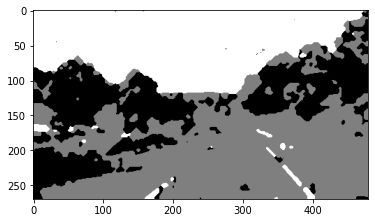

In [ ]:
    img = load_image('resized.jpg')
    var_dict = {0:[],1:[],2:[]}
    mu_dict = {0:[],1:[],2:[]}
    gray = rgb2gray(img)
    set_likelihood_prob(gray)
    extracted_features = feature_extraction(gray, num_f= 1, mode = 2)
    labels = simulated_annealing(extracted_features,betha=0.5,T0=1,c=0.999995,epochs=10000000,T_mode = 1)
    segmented_image = segmentaion(labels)
    print('segmented image')
    plt.imshow(segmented_image)

# part 2(a) --> HSV

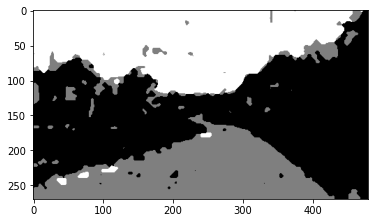

In [ ]:
    # img = load_image('resized.jpg')
    # img_hsv = rgb2hsv(img)
    # img_hsv = img_hsv[:,:,0] / float(max(img_hsv[:,:,0].flatten()))
    # plt.imshow(img_hsv)
    # plt.show()
    # var_dict = {0:[],1:[],2:[]}
    # mu_dict = {0:[],1:[],2:[]}
    # set_likelihood_prob(img_hsv)
    # extracted_features = feature_extraction(img_hsv, num_f= 1,mode = 2)
    # labels = simulated_annealing(extracted_features,betha=100,T0=1,c=0.999995,epochs=15000000,T_mode = 1)
    segmented_image = segmentaion(labels)
    # print(segmented_image)
    plt.imshow(segmented_image)
    plt.show()

# part 2(b) --> multi_feature

10000
u1: 44145381.69586187
20000
u1: 41951767.68717531
30000
u1: 39847848.09361284
40000
u1: 37872148.69972942
50000
u1: 35982520.480275646
60000
u1: 34127752.74979508
70000
u1: 32440849.967831623
80000
u1: 30783194.895360515
90000
u1: 29191436.862319384
100000
u1: 27750045.237007976
110000
u1: 26299377.262189273
120000
u1: 24972616.381948307
130000
u1: 23712584.18685154
140000
u1: 22515971.554734197
150000
u1: 21392146.355895486
160000
u1: 20303461.991763696
170000
u1: 19304152.35678666
180000
u1: 18282428.5293671
190000
u1: 17287445.053891905
200000
u1: 16416202.98475132
210000
u1: 15555784.213803913
220000
u1: 14724630.028669195
230000
u1: 13928806.228041878
240000
u1: 13202312.204092165
250000
u1: 12513459.941694753
260000
u1: 11867832.312599603
270000
u1: 11214411.153367529
280000
u1: 10558994.418986058
290000
u1: 9995623.859673718
300000
u1: 9439366.678272033
310000
u1: 8888704.285650836
320000
u1: 8385618.923403649
330000
u1: 7902282.235615238
340000
u1: 7437280.525553136
35000

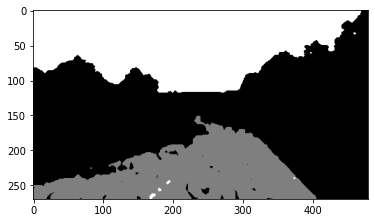

In [ ]:
    img = load_image('resized.jpg')
    extracted_features = feature_extraction(img, num_f= 4,mode =1 )
    set_likelihood_prob(extracted_features)
    labels = simulated_annealing(extracted_features,betha=10,T0=1,c=0.999995,epochs=10000000,T_mode = 1)
    segmented_image = segmentaion(labels)
    plt.imshow(segmented_image)

# optional part --> SuperPixel

In [ ]:
def feature_label_factor_v2(w_s, fs):
    var_s = var_dict.get(w_s)
    mu_s = mu_dict.get(w_s)
    if len(fs) == 1 :
        likelihood_factor = np.log(math.sqrt(var_s[0] * 2 * math.pi ))+ (0.5 * (np.dot(np.transpose(fs - mu_s), fs - mu_s)) / var_s[0])
    else:
        first = np.log(math.sqrt(abs(np.linalg.det(var_s)) * pow(2 * math.pi, len(fs))))
        second = (0.5 * np.dot((np.dot(np.transpose(fs - mu_s),np.linalg.inv(var_s))),fs - mu_s))
        likelihood_factor = first + second

    return likelihood_factor

def delta(w_s, w_r):

    if w_r == w_s:
        return -1
    else:
        return +1


def clique_energy_v2(W, F, neighbors, superpixel,betha,mode, prev_u, prev_w):
    n_states = F.shape[0]
    u = prev_u
    if mode == 1:
        for i in range(n_states):
            fs = F[i,:]
            u += feature_label_factor_v2(W[i],fs)

            # neighbors
            for j in list(neighbors.get(i)):
                u += betha * delta(W[i],W[j])

    elif mode == 2 :
        fs = F[superpixel, :]
        u -= feature_label_factor_v2(prev_w[superpixel], fs)
        u += feature_label_factor_v2(W[superpixel], fs)

        # neighbors
        for j in list(neighbors.get(superpixel)):
            u -= betha * delta(prev_w[superpixel], prev_w[j])
            u += betha * delta(W[superpixel], W[j])
          
    return u


def perturbation_v2(W):
    W_prim = W.copy()
    i = np.random.randint(0,W.shape[0],1)[0]
    res_labels = list(set({2,1,0}) - set({W[i]}))
    t = res_labels[random.randint(0,1)]
    W_prim[i] = t
    return W_prim ,i


def simulated_annealing_v2(states_neighbors, features,betha,T0,c,epochs,T_mode):
    n_states = features.shape[0]
    # initialization
    W = np.random.randint(0,3,[n_states])
    u1 = clique_energy_v2(W, features, states_neighbors, 0 ,betha = betha,mode = 1, prev_u = 0, prev_w = None)
    T = T0
    frozen = False
    k = 0
    patience = 0 
    while not frozen: 
        k += 1
        new_W ,i = perturbation_v2(W)
        u2 = clique_energy_v2(new_W, features, states_neighbors, i ,betha = betha,mode = 2, prev_u = u1, prev_w = W)
        delta_U = u2 - u1
        if delta_U <= 0:
            W = new_W.copy()
            u1 = u2.copy()
            patience = 0
        else:
            etha = random.uniform(0,1)
            if etha < math.exp(- delta_U / T):
                W = new_W.copy()
                u1 = u2.copy()
                patience = 0
            else:
                patience += 1 
        if patience > 10000:
            frozen = True
        if T_mode == 1:
            T =  T * c
        elif T_mode == 2:
            T =  T - c
        else: 
            T = T / np.log(k)
        if k % 10000 == 0:
            print(k)
            print('u1:', u1)
        if k > epochs:
            frozen = True
    return W


def feature_extraction_v2(image,states, n, num_f):
  features = np.zeros([n,num_f])
  index = 0
  for key in states.keys():
    superpixel_value = np.zeros([num_f])
    count = 0 
    for pixel in states.get(key):
      superpixel_value = np.add(superpixel_value,image[pixel[0],pixel[1]])
      count += 1
    if count > 0:
      superpixel_value = superpixel_value / count
      features[index,:] = superpixel_value
    else:
      print('else')
    index += 1
  return features


def set_likelihood_prob_v2(img):

    # var_dict.update({1: [np.var(img[212:268,125:350].flatten())]})
    # mu_dict.update({1: [np.mean(img[212:268,125:350].flatten())]})
    var_dict.update({1: np.cov([img[212:268,125:350,0].flatten(),img[212:268,125:350,1].flatten(),img[212:268,125:350,2].flatten()]) })
    mu_dict.update({1: [np.mean(img[212:268,125:350,0]),np.mean(img[212:268,125:350,1]),np.mean(img[212:268,125:350,2])]})
    

    # var_dict.update({0: [np.var(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})
    # mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})

    var_dict.update({0: np.cov([np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()]),
                                np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()]),
                                np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()])])})
    mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()])),
                        np.mean(np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()])),
                        np.mean(np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()]))]})   
    # sky
    # var_dict.update({2: [np.var(img[1:62,1:350].flatten())]})
    # mu_dict.update({2: [np.mean(img[1:62,1:350].flatten())]})
    var_dict.update({2: np.cov([img[1:62,1:350,0].flatten(),img[1:62,1:350,1].flatten(),img[1:62,1:350,2].flatten()])})
    mu_dict.update({2: [np.mean(img[1:62,1:350,0]),np.mean(img[1:62,1:350,1]),np.mean(img[1:62,1:350,2])]})
    
    print(var_dict,mu_dict)


def segmentaion_v2(labels, states,h,w):
    segmented_image = np.zeros((h, w,3), np.uint8)
    for key in states.keys():
      label = labels[key]
      if label == 1:
        label = 127
      elif label == 2:
        label = 255
      for pixel in states.get(key):
        segmented_image[pixel[0],pixel[1]] = [label,label,label]
        # segmented_image[pixel[0],pixel[1]] = label
    return segmented_image



In [ ]:
n_superpixels = 2000
var_dict = {0:[],1:[],2:[]}
mu_dict = {0:[],1:[],2:[]}

In [ ]:
def create_states(mask):
  states = {}
  height, width = mask.shape
  for i in range(height):
    for j in range(width):
      label = mask[i,j]
      if states.get(label) is None: 
        states.update({label: [[i,j]]})
      else:
        pixels = states.get(label)
        pixels.append([i,j])
        states.update({label:pixels})
  return states

In [ ]:
def get_neighbors(mask):
  neighbors = {}
  height, width = mask.shape
  for i in range(1,height-1):
    for j in range(1, width-1):
      for k in(-1,0,1):
        for s in(-1,0,1):
          if mask[i+k,j+s] != mask[i,j]:
            if neighbors.get(mask[i,j]) is None: 
              neighbors.update({mask[i,j]:{mask[i+k,j+s]}})
            else: 
              temp = neighbors.get(mask[i,j])
              temp.add(mask[i+k,j+s])
              neighbors.update({mask[i,j]:temp})
  return neighbors

{0: array([[ 950.97134917, 1002.56340611,  255.01082133],
       [1002.56340611, 1171.69961947,  274.87906905],
       [ 255.01082133,  274.87906905,  293.71275708]]), 1: array([[589.08584626, 570.28995161, 544.73257081],
       [570.28995161, 554.88380519, 530.33781356],
       [544.73257081, 530.33781356, 511.67537453]]), 2: array([[732.7998655 , 412.05634585,  93.31179116],
       [412.05634585, 239.24665025,  63.42377424],
       [ 93.31179116,  63.42377424,  38.62888494]])} {0: [53.844919416199765, 80.64847478730027, 21.50733208826174], 1: [93.14865079365079, 92.28825396825397, 91.09468253968254], 2: [128.79895720794778, 175.16623608436282, 230.37883413969655]}
10000
u1: 60474.3709894039
20000
u1: 24622.631947738013
30000
u1: 23377.178018712955
40000
u1: 23378.46059801224
50000
u1: 23378.46059801224
60000
u1: 23377.953653503468
70000
u1: 23377.82990430597
80000
u1: 23378.46059801224
90000
u1: 23377.953653503468
100000
u1: 23377.301767910452
110000
u1: 23377.178018712955
120000
u1:

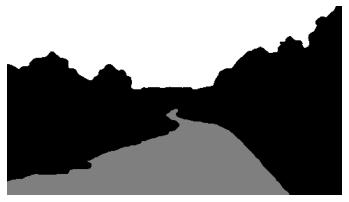

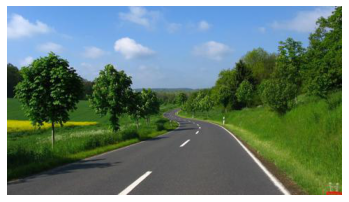

In [ ]:
img = load_image('resized.jpg')
image = img_as_float(img)
superpixels = slic(image, n_segments = n_superpixels, sigma = 2)
MRF_states = create_states(superpixels)
states_neighbors = get_neighbors(superpixels)

extracted_features = feature_extraction_v2(img,MRF_states, len(MRF_states.keys()), 3)
set_likelihood_prob_v2(img)
labels = simulated_annealing_v2(states_neighbors, extracted_features,betha=0.5,T0=1,c=0.999995,epochs=1000000,T_mode = 1)
segmented_image = segmentaion_v2(labels,MRF_states,img.shape[0],img.shape[1])
plt.axis("off")
plt.imshow(segmented_image)
plt.show()

plt.imshow(img)
plt.axis("off")
plt.show()


# Optional part --> Hierarchical

In [ ]:
var_dict = {0:[],1:[],2:[]}
mu_dict = {0:[],1:[],2:[]}

In [ ]:
def feature_label_factor_v2(w_s, fs):
    var_s = var_dict.get(w_s)
    mu_s = mu_dict.get(w_s)
    if len(fs) == 1 :
        likelihood_factor = np.log(math.sqrt(var_s[0] * 2 * math.pi ))+ (0.5 * (np.dot(np.transpose(fs - mu_s), fs - mu_s)) / var_s[0])
    else:
        first = np.log(math.sqrt(abs(np.linalg.det(var_s)) * pow(2 * math.pi, len(fs))))
        second = (0.5 * np.dot((np.dot(np.transpose(fs - mu_s),np.linalg.inv(var_s))),fs - mu_s))
        likelihood_factor = first + second

    return likelihood_factor

def delta(w_s, w_r):

    if w_r == w_s:
        return -1
    else:
        return +1


def clique_energy_v3(W, F, neighbors, superpixel,betha,mode, prev_u, prev_w):
    n_states = len(F)
    u = prev_u
    # print(u)
    if mode == 1:
        for state_name in F.keys():
            fs = F.get(state_name)
            u += feature_label_factor_v2(W.get(state_name),fs)

            # neighbors
            for neighbor in list(neighbors.get(state_name)):
                u += betha * delta(W.get(state_name),W.get(neighbor))

    elif mode == 2 :
        if F.get(superpixel) is not None:
          fs = F.get(superpixel)
          u -= feature_label_factor_v2(prev_w.get(superpixel), fs)
          u += feature_label_factor_v2(W.get(superpixel), fs)
          # print(u)
          # neighbors
          for neighbor in list(neighbors.get(superpixel)):
            u -= betha * delta(prev_w.get(superpixel), prev_w.get(neighbor))
            u += betha * delta(W.get(superpixel), W.get(neighbor))
          # print(u) 
          # print("00000000000000000000000000000")  
    return u



def perturbation_v3(W):
    W_prim = W.copy()
    keys = list(W.keys())
    i = np.random.randint(0,len(keys),1)[0]
    res_labels = list(set({2,1,0}) - set({W.get(keys[i])}))
    t = res_labels[random.randint(0,1)]
    W_prim.update({i:t})
    return W_prim ,keys[i]


def merge_states(W,features,prev_neighbors,cur_states,changed_state):
  new_neighbors = prev_neighbors.copy()
  new_features = features.copy()
  new_states = cur_states.copy()
  if prev_neighbors.get(changed_state) is None: 
    return W, features, prev_neighbors, cur_states
  else:
    neighbors = prev_neighbors.get(changed_state).copy()
  merged_states = [changed_state]
  merged_neighbors = list(prev_neighbors.get(changed_state).copy())


  for neighbor in neighbors:
    if W.get(neighbor) == W.get(changed_state):
      merged_states.append(neighbor)
      merged_neighbors = merged_neighbors + list(prev_neighbors.get(neighbor))

  merged_neighbors = set(merged_neighbors)
  merged_neighbors = merged_neighbors - set(merged_states)

  for nei in merged_neighbors:
    elements = prev_neighbors.get(nei)
    new_elements = set()
    for item in elements:
      if item  not in merged_states:
        new_elements.add(item)
    new_elements.add(changed_state)
    new_neighbors.update({nei:new_elements})


  merged_states.remove(changed_state)


  # update neighbors 
  for state in merged_states:
    del new_neighbors[state]
  new_neighbors.update({changed_state:merged_neighbors})

  # update features
  F = features.get(changed_state)
  for state in merged_states:
    F = np.add(F,features.get(state))
    del new_features[state]
  F = F / (len(merged_states) + 1)
  new_features.update({changed_state: F})


  # update states
  pixels = cur_states.get(changed_state)
  for state in merged_states:
    pixels = pixels + cur_states.get(state)
    del new_states[state]
  new_states.update({changed_state:pixels})

  # update labels
  new_W = {}
  for key in new_states.keys():
    new_W.update({key:W.get(key)})

  return new_W, new_features, new_neighbors,new_states
  

def simulated_annealing_v3(states,states_neighbors, features,betha,T0,c,epochs,T_mode):

    # initialization
    W = {}
    for key in features.keys():
      W.update({key:np.random.randint(0,3,1)[0]})
    u1 = clique_energy_v3(W, features, states_neighbors, 0 ,betha = betha,mode = 1, prev_u = 0, prev_w = None)
    T = T0
    frozen = False
    k = 0
    patience = 0 
    counter = 0
    flag = False
    while not frozen: 
        k += 1
        if flag :
          new_W ,i = perturbation_v3(W_prim)
        else:
          new_W ,i = perturbation_v3(W)
        # print(len(new_W))
        u2 = clique_energy_v3(new_W, features, states_neighbors, i ,betha = betha,mode = 2, prev_u = u1, prev_w = W)
        delta_U = u2 - u1
        if delta_U <= 0:
            W = new_W.copy()
            u1 = u2.copy()
            patience = 0
            if k > 10000:
              W_prim, features, states_neighbors,states = merge_states(W,features,states_neighbors,states,i)
              flag = True
        else:
            etha = random.uniform(0,1)
            if etha < math.exp(- delta_U / T):
                W = new_W.copy()
                u1 = u2.copy()
                patience = 0
            else:
                patience += 1
            flag = False 
        if patience > 1000:
            frozen = True
        if T_mode == 1:
            T =  T * c
        elif T_mode == 2:
            T =  T - c
        else: 
            T = T / np.log(k)
        if k % 100 == 0:
            print(k)
            print('u1:', u1)
        if k > epochs:
            frozen = True
    return W, states


def feature_extraction_v3(image,states):
  features = {}
  for key in states.keys():
    superpixel_value = np.zeros([3])
    count = 0 
    for pixel in states.get(key):
      superpixel_value = np.add(superpixel_value,image[pixel[0],pixel[1]])
      count += 1
    if count > 0:
      superpixel_value = superpixel_value / count
      features.update({key: superpixel_value})
    else:
      print('else')
  return features

def segmentaion_v2(labels, states,h,w):
    segmented_image = np.zeros((h, w, 3), np.uint8)
    for key in states.keys():
      label = labels[key]
      if label == 1:
        label = 127
      elif label == 2:
        label = 255
      for pixel in states.get(key):
        segmented_image[pixel[0],pixel[1]] = [label,label,label]
    return segmented_image

def set_likelihood_prob_v2(img):

    # var_dict.update({1: [np.var(img[212:268,125:350].flatten())]})
    # mu_dict.update({1: [np.mean(img[212:268,125:350].flatten())]})
    var_dict.update({1: np.cov([img[212:268,125:350,0].flatten(),img[212:268,125:350,1].flatten(),img[212:268,125:350,2].flatten()]) })
    mu_dict.update({1: [np.mean(img[212:268,125:350,0]),np.mean(img[212:268,125:350,1]),np.mean(img[212:268,125:350,2])]})
    

    # var_dict.update({0: [np.var(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})
    # mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125].flatten(), img[70:187,337:479].flatten()]))]})

    var_dict.update({0: np.cov([np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()]),
                                np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()]),
                                np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()])])})
    mu_dict.update({0: [np.mean(np.concatenate([img[112:212, 2:125,0].flatten(), img[70:187,337:479,0].flatten()])),
                        np.mean(np.concatenate([img[112:212, 2:125,1].flatten(), img[70:187,337:479,1].flatten()])),
                        np.mean(np.concatenate([img[112:212, 2:125,2].flatten(), img[70:187,337:479,2].flatten()]))]})   
    # sky
    # var_dict.update({2: [np.var(img[1:62,1:350].flatten())]})
    # mu_dict.update({2: [np.mean(img[1:62,1:350].flatten())]})
    var_dict.update({2: np.cov([img[1:62,1:350,0].flatten(),img[1:62,1:350,1].flatten(),img[1:62,1:350,2].flatten()])})
    mu_dict.update({2: [np.mean(img[1:62,1:350,0]),np.mean(img[1:62,1:350,1]),np.mean(img[1:62,1:350,2])]})
    
    print(var_dict,mu_dict)


In [ ]:
def init_states(image):
  states = {}
  height, width, ch = image.shape
  mask = np.zeros((height,width))
  pix_n = 0 
  for i in range(height):
    for j in range(width):
      states.update({pix_n: [[i,j]]})
      mask[i,j] = pix_n
      pix_n += 1
  return mask.astype(int), states

In [ ]:
def get_neighbors(mask):  # mask.shape = image shape
  neighbors = {}
  height, width = mask.shape
  for i in range(1,height-1):
    for j in range(1, width-1):
      for k in(-1,0,1):
        for s in(-1,0,1):
          if mask[i+k,j+s] != mask[i,j]:
            if neighbors.get(mask[i,j]) is None: 
              neighbors.update({mask[i,j]:{mask[i+k,j+s]}})
            else: 
              temp = neighbors.get(mask[i,j])
              temp.add(mask[i+k,j+s])
              neighbors.update({mask[i,j]:temp})
  for col in range(1,width - 1):
    for r in [-1,0,1]:
      for t in [0,1]:
        if mask[t,col+r] != mask[0,col]:
            if neighbors.get(mask[0,col]) is None: 
              neighbors.update({mask[0,col]:{mask[t,col+r]}})
            else: 
              temp = neighbors.get(mask[0,col])
              temp.add(mask[t,col+r])
              neighbors.update({mask[0,col]:temp})
      for o in [-1,0]:
        if mask[height-1+o,col+r] != mask[height-1,col]:
            if neighbors.get(mask[height-1,col]) is None: 
              neighbors.update({mask[height-1,col]:{mask[height-1+o,col+r]}})
            else: 
              temp = neighbors.get(mask[height-1,col])
              temp.add(mask[height-1+o,col+r])
              neighbors.update({mask[height-1,col]:temp})
  for row in range(1,height-1):
    for r1 in [-1,0,1]:
      for t1 in [0,1]:
        if mask[row+r1,t1] != mask[row,0]:
            if neighbors.get(mask[row,0]) is None: 
              neighbors.update({mask[row,0]:{mask[row+r1,t1]}})
            else: 
              temp = neighbors.get(mask[row,0])
              temp.add(mask[row+r1,t1])
              neighbors.update({mask[row,0]:temp})
      for o1 in [-1,0]:
        if mask[row+r1,width-1+o1] != mask[row,width-1]:
            if neighbors.get(mask[row,width-1]) is None: 
              neighbors.update({mask[row,width-1]:{mask[row+r1,width-1+o1]}})
            else: 
              temp = neighbors.get(mask[row,width-1])
              temp.add(mask[row+r1,width-1+o1])
              neighbors.update({mask[row,width-1]:temp})

  neighbors.update({mask[0,0]:{mask[0,1],mask[1,1],mask[1,0]}})
  neighbors.update({mask[0,width - 1]:{mask[0,width-2],mask[1,width- 1 ],mask[1,width - 2]}})
  neighbors.update({mask[height - 1,0]:{mask[height - 1 ,1],mask[height - 2,1],mask[height - 2,0]}})
  neighbors.update({mask[height-1,width - 1]:{mask[height-1,width - 2],mask[height - 2,width -1],mask[height - 2,width -2]}})
  return neighbors

In [ ]:
# img = load_image('resized.jpg')
init_mask, initial_states = init_states(img)
states_neighbors = get_neighbors(init_mask)

# n_superpixels = 200
# image = img_as_float(img)
# superpixels = slic(image, n_segments = n_superpixels, sigma = 2)
# initial_states = create_states(superpixels)
# states_neighbors = get_neighbors(superpixels)

extracted_features = feature_extraction_v3(img,initial_states)
set_likelihood_prob_v2(img)
labels, new_states = simulated_annealing_v3(initial_states,states_neighbors, extracted_features,betha=1,T0=1,c=0.999995,epochs=1000000,T_mode = 1)
segmented_image = segmentaion_v2(labels,new_states,img.shape[0],img.shape[1])
plt.axis("off")
plt.imshow(segmented_image)
plt.show()

# plt.imshow(img)
# plt.axis("off")
# plt.show()
# print(img.shape)

# test_ hierarchical

In [ ]:
def simulated_annealing_v2(states_neighbors, features,betha,T0,c,epochs,T_mode):
    n_states = features.shape[0]
    # initialization
    W = np.random.randint(0,3,[n_states])
    u1 = clique_energy_v2(W, features, states_neighbors, 0 ,betha = betha,mode = 1, prev_u = 0, prev_w = None)
    T = T0
    frozen = False
    k = 0
    patience = 0 
    while not frozen: 
        k += 1
        new_W ,i = perturbation_v2(W)
        u2 = clique_energy_v2(new_W, features, states_neighbors, i ,betha = betha,mode = 2, prev_u = u1, prev_w = W)
        delta_U = u2 - u1
        if delta_U <= 0:
            W = new_W.copy()
            u1 = u2.copy()
            patience = 0
        else:
            etha = random.uniform(0,1)
            if etha < math.exp(- delta_U / T):
                W = new_W.copy()
                u1 = u2.copy()
                patience = 0
            else:
                patience += 1 
        if patience > 10000:
            frozen = True
        if T_mode == 1:
            T =  T * c
        elif T_mode == 2:
            T =  T - c
        else: 
            T = T / np.log(k)
        if k % 10000 == 0:
            print(k)
            print('u1:', u1)
        if k > epochs:
            frozen = True
    return W,u1



{0: array([[ 950.97134917, 1002.56340611,  255.01082133],
       [1002.56340611, 1171.69961947,  274.87906905],
       [ 255.01082133,  274.87906905,  293.71275708]]), 1: array([[589.08584626, 570.28995161, 544.73257081],
       [570.28995161, 554.88380519, 530.33781356],
       [544.73257081, 530.33781356, 511.67537453]]), 2: array([[732.7998655 , 412.05634585,  93.31179116],
       [412.05634585, 239.24665025,  63.42377424],
       [ 93.31179116,  63.42377424,  38.62888494]])} {0: [53.844919416199765, 80.64847478730027, 21.50733208826174], 1: [93.14865079365079, 92.28825396825397, 91.09468253968254], 2: [128.79895720794778, 175.16623608436282, 230.37883413969655]}
2


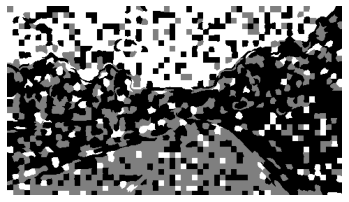

35718.83059142477
3


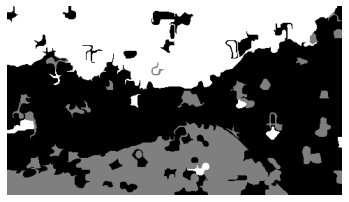

15915.878470140244
4


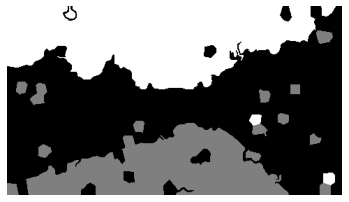

9507.402164622643
5


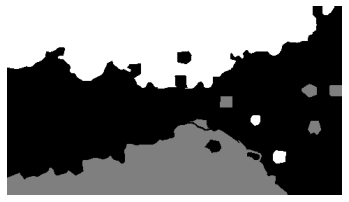

4509.584087821064
6


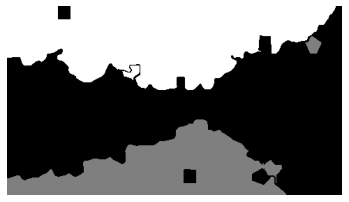

4157.235379025258
7


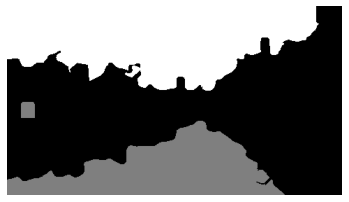

3447.8471376524867
8


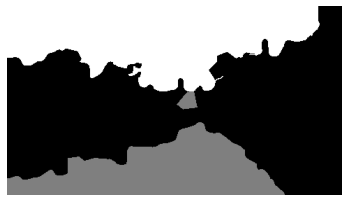

2522.4102038746923
9


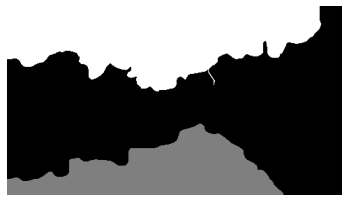

2492.4364476857504
10


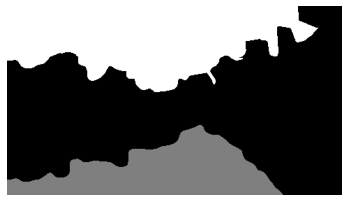

2252.6851414301714
11


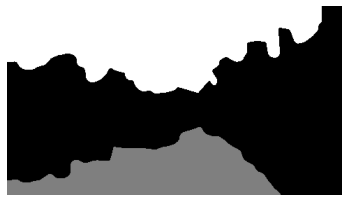

1914.761516929262


In [ ]:
n_superpixels = 2000
var_dict = {0:[],1:[],2:[]}
mu_dict = {0:[],1:[],2:[]}
set_likelihood_prob_v2(img)
img = load_image('resized.jpg')
image = img_as_float(img)
superpixels = slic(image, n_segments = n_superpixels, sigma = 2)

MRF_states = create_states(superpixels)
states_neighbors = get_neighbors(superpixels)
extracted_features = feature_extraction_v2(img,MRF_states, len(MRF_states.keys()), 3)
labels, u1 = simulated_annealing_v2(states_neighbors, extracted_features,betha=0.5,T0=1,c=0.999995,epochs=3000,T_mode = 1)
flag = True
i = 2 
while flag:
  segmented_image = segmentaion_v2(labels,MRF_states,img.shape[0],img.shape[1])
  print(i)
  plt.axis("off")
  plt.imshow(segmented_image)
  plt.show()
  image = img_as_float(segmented_image)
  superpixels = slic(image, n_segments = (n_superpixels / i ) , sigma = 2)
  MRF_states = create_states(superpixels)
  states_neighbors = get_neighbors(superpixels)
  extracted_features = feature_extraction_v2(img,MRF_states, len(MRF_states.keys()), 3)
  labels, u2 = simulated_annealing_v2(states_neighbors, extracted_features,betha=0.5,T0=1,c=0.999995,epochs=3000,T_mode = 1)
  i += 1 
  print(u2)
  if u2 < 2000:
    flag = False
  
  
  

# plt.axis("off")
# plt.imshow(segmented_image)
# plt.show()

# plt.imshow(img)
# plt.axis("off")
# plt.show()